# The fundamental matrix and 3D reconstruction

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from IPython import display

### Activity 1:

Watch the fundamental matrix song for a brief recap of this weeks lecture videos. https://www.youtube.com/watch?v=DgGV3l82NTk

Ok. Let's try to understand this video.

In [2]:
im_1 = cv2.imread('../test_images/lego_1.jpg')[:,:,[2,1,0]]
im_2 = cv2.imread('../test_images/lego_2.jpg')[:,:,[2,1,0]]

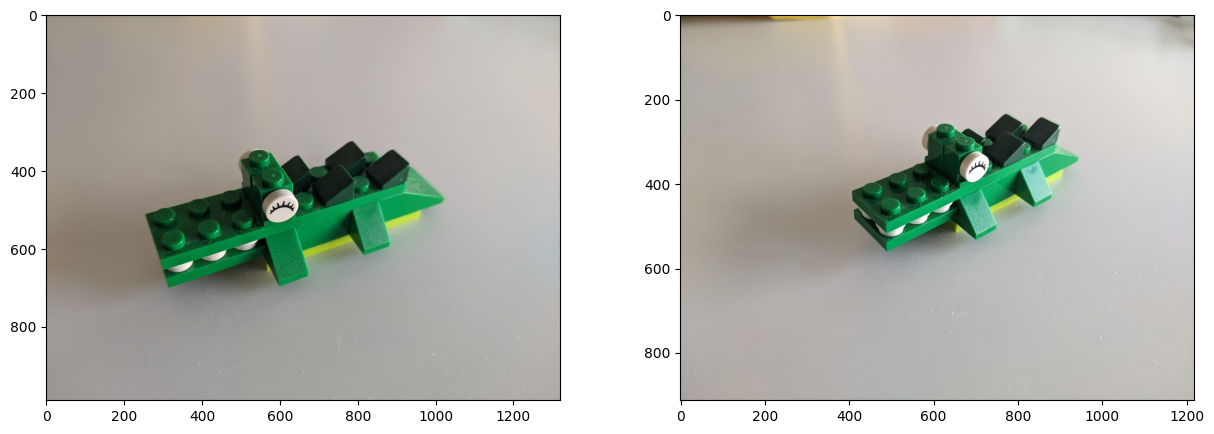

In [3]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(im_1)
plt.subplot(1,2,2)
plt.imshow(im_2)
plt.show()

In [4]:
# Initiate orb
orb = cv2.ORB_create()

# Find the keypoints and descriptors
kp1, des1 = orb.detectAndCompute(im_1,None)
kp2, des2 = orb.detectAndCompute(im_2,None)

In [5]:
# Match keypoints
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)

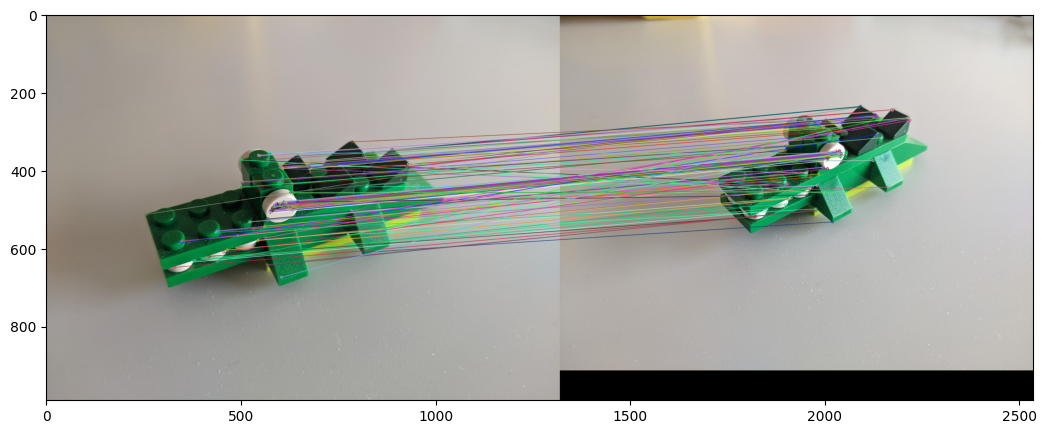

In [6]:
# Draw all matches
plt.figure(figsize=(15,5))
img3 = cv2.drawMatches(im_1,kp1,im_2,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.show()

In [7]:
# Find keypoint correspondences
X1 = np.vstack([kp1[match.queryIdx].pt for match in matches])
X2 = np.vstack([kp2[match.trainIdx].pt for match in matches])

Find fundamental matrix using OpenCV 

In [8]:
# 8-point algorithm approach
# In general, it's harder to get a robust estimate of F, so good practices are, normalise image coordinates 
# Build matrix A from correspondences, extract F using SVD
# Compute SVD of F
# Enforce zero determinant by setting last singular value to zero
# Recompute F using USV^T
# De-normalise F

 # This is a fancier iterative method using Levenberg-Marquardt optimisation to minimise epipolar error
F, mask = cv2.findFundamentalMat(X1,X2,cv2.FM_LMEDS)

In [9]:
def draw_lines_and_points(im_1,lines,X):
    cols = ['C0','C1','C2','C3','C4','C5']
    i = 0
    for r,pt in zip(lines[:5],X[:5]):
        c = cols[i]
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [im_1.shape[1], -(r[2]+r[0]*im_1.shape[1])/r[1] ])
        plt.plot([x0,x1],[y0,y1],'-o',color=c)
        plt.plot([pt[0]],[pt[1]],'o',color=c)
        i = i +1
        

Paraphrasing the song: Post-multiplying x by F results in an epipolar lines). 

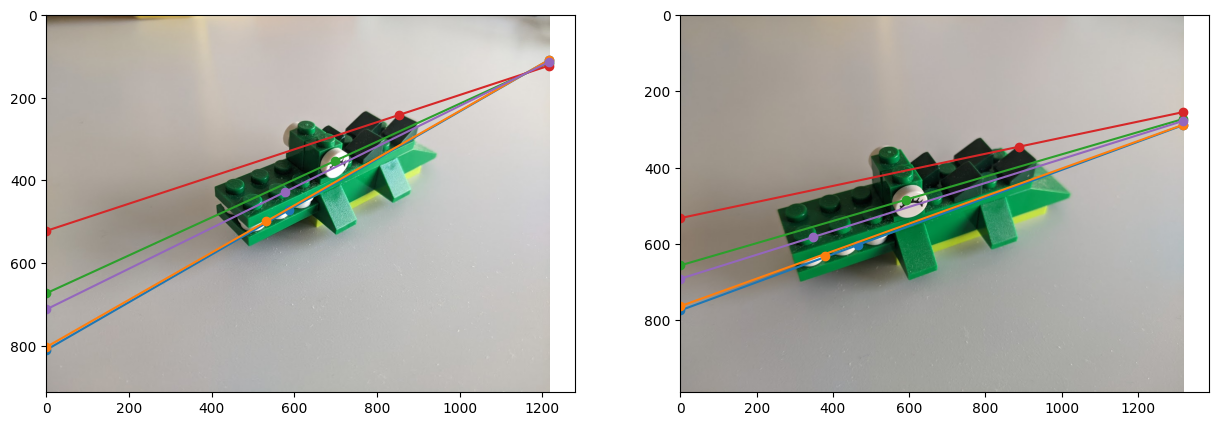

In [10]:
lines2 = F@np.hstack([X1,np.ones((X1.shape[0],1))]).T
lines1 = F.T@np.hstack([X2,np.ones((X2.shape[0],1))]).T

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(im_2)

draw_lines_and_points(im_2,lines2.T,X2)

plt.subplot(1,2,2)
plt.imshow(im_1)
draw_lines_and_points(im_1,lines1.T,X1)
plt.show()

The epipoles are in the left and right null spaces of F. All epipolar lines pass through the epipoles.

In [11]:
U,S,Vt = np.linalg.svd(F)
epipole_1 = Vt[-1,:]/Vt[-1,-1]

U,S,Vt = np.linalg.svd(F.T)
epipole_2 = Vt[-1,:]/Vt[-1,-1]

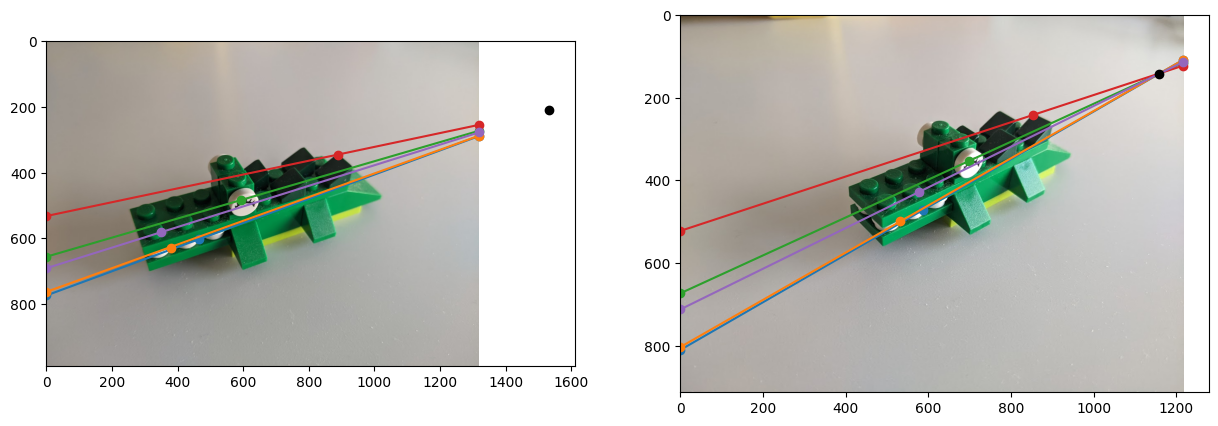

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(im_1)
draw_lines_and_points(im_1,lines1.T,X1)

plt.plot(epipole_1[0],epipole_1[1],'ko')

plt.subplot(1,2,2)
plt.imshow(im_2)
draw_lines_and_points(im_2,lines2.T,X2)

plt.plot(epipole_2[0],epipole_2[1],'ko')
    

plt.show()

Let's assume I have already calibrated my camera, and have intrinsic matrix 

$K = \begin{bmatrix}f & 0 & x_c\\0 & f & y_c\\ 0 & 0 & 1 \end{bmatrix}$

We know that the essential matrix $\mathbf{E}$ is related to the fundamental matrix as

$\mathbf{F} = \mathbf{K_2}^{-\text{T}} \mathbf{E} \mathbf{K_1}^{-1}$

so could solve for $\mathbf{E}$.

In [13]:
K =  np.array([[982.58476312, 0., 611.35192207],
             [0., 985.12962747, 436.11543958],
             [0., 0., 1.]])

print(K)

[[982.58476312   0.         611.35192207]
 [  0.         985.12962747 436.11543958]
 [  0.           0.           1.        ]]


In [14]:
E = K.T@F@K

Now let's decompose the matrix E to try to solve for the rotation and translation of the second camera viewpoint, relative to the first. In our notes we saw that the essential matrix could be composed as

$\mathbf{E} = \begin{bmatrix} t_1 \\ t_2 \\ t_3 \end{bmatrix} \times \mathbf{R} $

We want to reverse this, to solve for t and R. We also saw in the notes that we can write a cross product as matrix multiplication

$\mathbf{E} = \begin{bmatrix} 0 & -t_3 & t_2 \\ t_3 & 0 & -t_1 \\ -t_2 & t_1 & 0 \end{bmatrix} \mathbf{R}$

The SVD decomposes E into two orthogonal matrices and a diagonal matrix of singular values, and for essential matrices the last singular value is zero.

In [15]:
R1, R2, t = cv2.decomposeEssentialMat(E)

#### Some non-examinable material (what happens inside this function)
We can then use this and some properties of the SVD to get some possible decompositions into t and R. Unfortunately, there are multiple possible solutions to this decomposition. We have to check all of these, and choose the correct one (usually the one with the points in front of the camera - sometimes called chierality constraints).

The pose recovery theorem says:

$$ \mathbf{E} = \mathbf{U}\mathbf{\Sigma}\mathbf{V}^\text{T} $$

$$ (\mathbf{t}_1,\mathbf{R}_1) = \left(\mathbf{U}\mathbf{R}_z(+\frac{\pi}{2})\mathbf{\Sigma}\mathbf{U}^\text{T},\mathbf{U}\mathbf{R}_z(+\frac{\pi}{2})\mathbf{V}^\text{T}\right)$$
$$ (\mathbf{t}_2,\mathbf{R}_2) = \left(\mathbf{U}\mathbf{R}_z(-\frac{\pi}{2})\mathbf{\Sigma}\mathbf{U}^\text{T},\mathbf{U}\mathbf{R}_z(-\frac{\pi}{2})\mathbf{V}^\text{T}\right)$$

where 

$$\mathbf{R}_z(+\frac{\pi}{2}) = \begin{bmatrix}0 & -1 & 0\\ 1 & 0 & 0\\ 0 & 0 & 1\end{bmatrix}$$

In [16]:
P2_1 = K@np.hstack([R1,t.reshape(-1,1)]) # Second camera view
P2_2 = K@np.hstack([R2,t.reshape(-1,1)])

P1 = K@np.hstack([np.eye(3), np.zeros((3,1))]) # First camera view

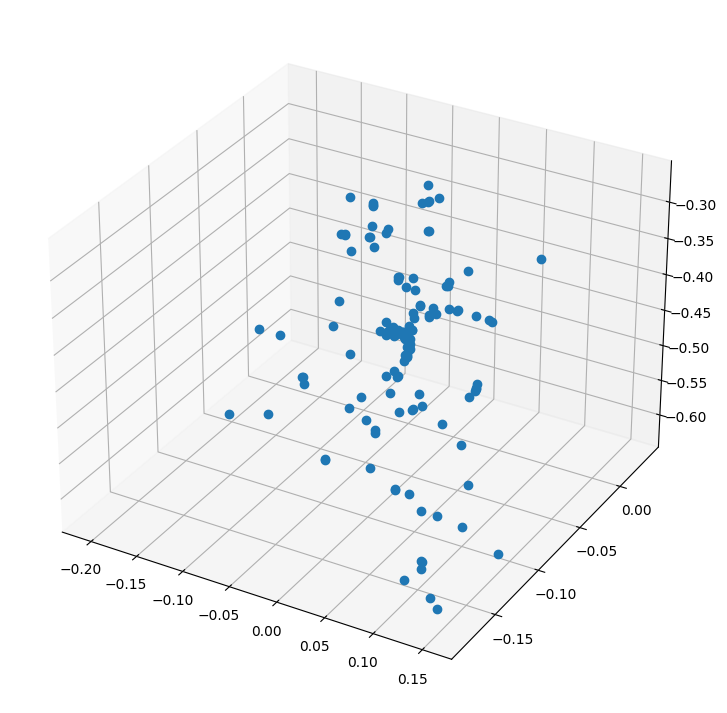

In [17]:
points_3d = cv2.triangulatePoints(P1,P2_1,X1.T,X2.T)
points_3d = points_3d/points_3d[-1,:]

fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection='3d')
plt.plot(points_3d[0,:],points_3d[1,:],points_3d[2,:],'o')
plt.show()

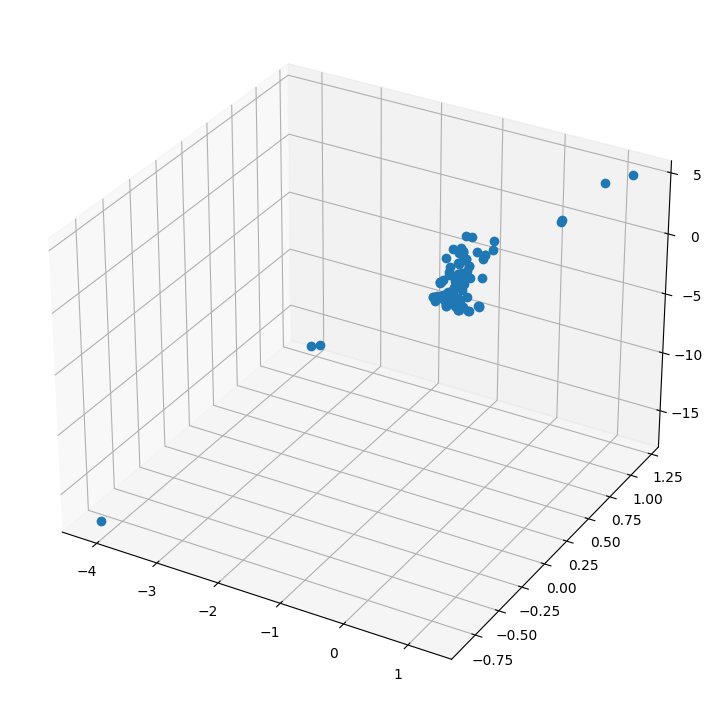

In [18]:
points_3d = cv2.triangulatePoints(P1,P2_2,X1.T,X2.T)
points_3d = points_3d/points_3d[-1,:]

fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection='3d')
ax.plot(points_3d[0,:],points_3d[1,:],points_3d[2,:],'o')
plt.show()

These points look vaguely sensible, but are quite sparse, so it's hard to tell. 

This is a problem with feature-based reconstruction. Active camera approaches like structured light approaches attempt to address this sparsity by projecting a pattern into a scene while imaging, to make it easier to find correspondences, particularly in textureless scenes.


### Activity 2

If we wanted to avoid this sparsity and perform dense stereo reconstruction, what constraints could we exploit? 

- Assume a parallel camera pair and list a few possible ways to address the correspondence problem.  

The approach above gave us a sparse 3D reconstruction, but also the camera pose between two views.

- Discuss how you could track how a camera has moved in space (visual odometry)?



### Space Carving

As an alternative to triangulation, we could try space carving. Here, we'll start with a 3D voxel grid, project this into a scene, and keep only those pixels that agree.

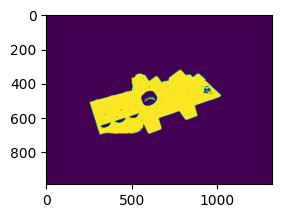

In [19]:
sil_1 = im_1[:,:,0]<100

plt.subplot(1,2,1)
plt.imshow(sil_1)
plt.show()

In [20]:
N = 50
xx,yy,zz = np.meshgrid(np.linspace(-1,1,N),np.linspace(-1,1,N),np.linspace(-0.1,-1.5,N))
X = np.vstack((xx.ravel(),yy.ravel(),zz.ravel(),np.ones(N*N*N)))
Occupancy = np.zeros([N,N,N],dtype=bool)

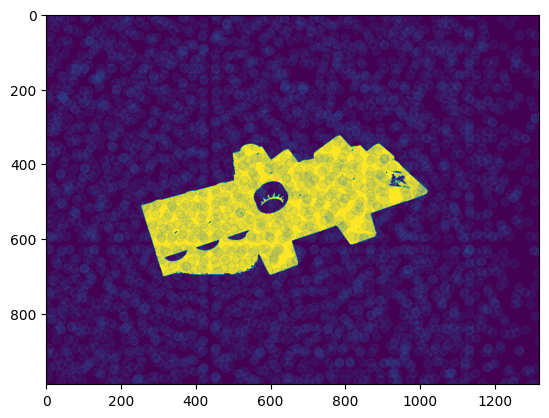

In [21]:
# Project voxels into first image
xim = P1@X
xim = xim/xim[2,:]

# Get voxels in camera field of view
bins_im = ((xim[0,:]>0)&(xim[0,:]<im_1.shape[0])&(xim[1,:]>0)&(xim[1,:]<im_1.shape[1]))
coords = xim[0:2,bins_im].copy().astype(int)

# Only voxels projecting onto silhoutte can be occupied 
Occupancy.ravel()[bins_im] = sil_1[coords[0,:],coords[1,:]]

# Every 10th point projected onto image
plt.plot(coords[1,::10],coords[0,::10],'o',alpha=0.1)
plt.imshow(sil_1)
plt.show()

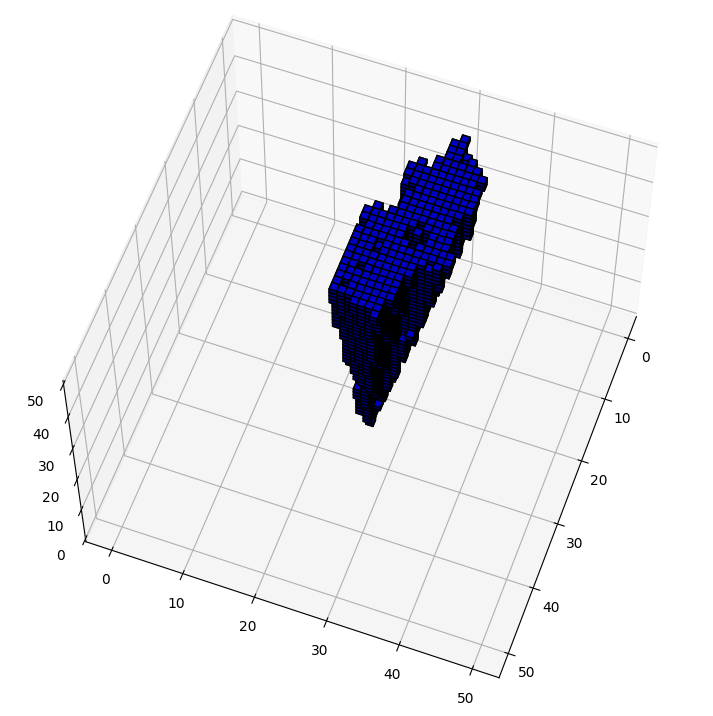

In [22]:
fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection='3d')
colours = np.empty(Occupancy.shape, dtype=object)
colours[Occupancy] = 'blue'
ax.voxels(Occupancy, facecolors=colours, edgecolor='k')
ax.view_init(60,20)
plt.show()

As discussed in the lecture videos, by adding multiple views from different angles, we could continue to carve out the voxels, until only those attached to our object remain. Here's a nice computerphile [overview](https://www.youtube.com/watch?v=cGs90KF4oTc) and a nice [tutorial](https://blogs.mathworks.com/loren/2009/12/16/carving-a-dinosaur/?doing_wp_cron=1644893843.8964691162109375000000) describing this approach. 